In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt    
import os
import random

In [48]:
dataPath = r'./data/word_embedding/text8'
wordCountUpperBound = 5000
sentenceLength = 100

In [49]:
with open(dataPath, "r") as f:
    text = f.read()
tokens = text.lower().split()
text = [" ".join(tokens[i:(i+sentenceLength)]) for i in range(0, len(tokens), sentenceLength)]

In [50]:
encoded, word2idx = tokenize(text)

In [52]:
pairLen = 2

In [ ]:
pairs = []
for sentence in encoded:
    for i, ids in enumerate(sentence):
        sentenceLength = len(sentence)
        for j in range(max(0, i-pairLen), min(sentenceLength, i+pairLen+1)):
            if j == i:
                pass
            else:
                pairs.append((ids, sentence[j]))

In [63]:
pairsDf = pd.DataFrame(pairs, columns=["x", "y"])

In [66]:
test_size=0.2
xTrain, xTest, yTrain, yTest = train_test_split(pairsDf['x'], pairsDf['y'], test_size=test_size)

In [69]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from utils.word_to_index import tokenize
from utils.DataSetForDataLoader import numericDataset

def _load_text8_data(dataPath, wordCountUpperBound = 5000, sentenceLength = 100):
    with open(dataPath, "r") as f:
        text = f.read()
    tokens = text.lower().split()
    text = [" ".join(tokens[i:(i+sentenceLength)]) for i in range(0, len(tokens), sentenceLength)]
    return text

def _get_pairs_from_encoded(encoded,pairLen = 2):
    pairs = []
    for sentence in encoded:
        for i, ids in enumerate(sentence):
            sentenceLength = len(sentence)
            for j in range(max(0, i-pairLen), min(sentenceLength, i+pairLen+1)):
                if j == i:
                    pass
                else:
                    pairs.append((ids, sentence[j]))
    pairsDf = pd.DataFrame(pairs, columns=["x", "y"])
    return pairsDf


def _transfer_xy_to_DataLoader(x,y,xType=torch.float32, yType=torch.float32,test_size=0.2,batch_size=32):
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=test_size)
    trainData = numericDataset(xTrain, yTrain, xType, yType)
    testData = numericDataset(xTest, yTest, xType, yType)
    trainDataLoader = DataLoader(trainData, batch_size, shuffle=True)
    testDataLoader = DataLoader(testData, batch_size)
    data = {
        'trainDataLoader':trainDataLoader,
        'testDataLoader':testDataLoader
    }
    return data

In [ ]:
text = _load_text8_data(dataPath, wordCountUpperBound = 5000, sentenceLength = 100)
encoded, word2idx = tokenize(text)
pairsDf = _get_pairs_from_encoded(encoded,pairLen = 2)
data = _transfer_xy_to_DataLoader(pairsDf['x'].values,pairsDf['y'].values,xType=torch.int64, yType=torch.int64,test_size=0.2,batch_size=32)

ValueError: could not determine the shape of object type 'Series'

In [ ]:
class Word2Vec(nn.Module):
    def __init__(self, vocabSize, embeddingDim):
        super().__init__()
        self.inBed = nn.Embedding(vocabSize,embeddingDim)
        self.out_embed = nn.Linear(embeddingDim, vocabSize)
    
    def forward(self, center):
        emb = self.in_embed(center)
        out = self.out_embed(emb)
        return out

In [37]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, embedding_dim)
        self.out_embed = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, center):
        emb = self.in_embed(center)
        out = self.out_embed(emb)
        return out


In [38]:
embedding_dim = 10
model = Word2Vec(len(vocab), embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [39]:
for epoch in range(100):
    total_loss = 0
    for center, context in data:
        center = torch.tensor([center])
        context = torch.tensor([context])
        
        optimizer.zero_grad()
        output = model(center)
        loss = criterion(output, context)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 20, Loss: 130.4662
Epoch 40, Loss: 126.2432
Epoch 60, Loss: 125.0713
Epoch 80, Loss: 124.4988
Epoch 100, Loss: 124.1427


In [40]:
embeddings = model.in_embed.weight.data
for i, w in idx2word.items():
    print(f"{w:12s} -> {embeddings[i].numpy()}")

we           -> [ 1.1901355   0.1000333   0.04869878  0.2631921  -0.16399704 -0.87899303
  0.4444092   2.858483    1.8488451  -1.5682485 ]
love         -> [ 0.29463562 -0.40477306  1.6140559  -0.30851766  0.56875074  0.72260153
 -1.5058414  -1.6075313   1.9511546  -0.8733204 ]
deep         -> [-2.6896584   1.9199921   0.638249    2.7615266  -1.9434866   1.8072709
 -1.1420976   1.0083597   0.80349046 -0.66859084]
learning     -> [ 1.4914303  -1.136825   -0.23761687  1.0050106   0.02167322  0.36290377
  0.33304337  0.9910694  -0.41967535  0.9833413 ]
is           -> [ 1.787133    0.8307893   0.2649182   0.4350209   0.29697642 -0.0064349
 -0.20126507 -1.1883416  -0.38971543 -1.155351  ]
part         -> [-0.2740633 -1.3940176 -1.4662576  1.0299851  1.0990431  1.1458284
 -2.1845803 -0.8270776 -2.2024164 -0.3912943]
of           -> [ 0.18762475 -1.5098001   1.1762775   0.3885279  -1.2421465  -0.18490422
 -0.76828897 -0.89049345 -3.053025   -0.03569504]
machine      -> [-0.49731812 -1.2245141

In [14]:
from utils.DataSetForDataLoader import TextDataset

xTrain, xTest, yTrain, yTest = train_test_split(encodedTexts3d, labels, test_size=0.2)
trainData = TextDataset(xTrain, yTrain, torch.float32, torch.float32)
testData = TextDataset(xTest, yTest, torch.float32, torch.float32)
trainDataLoader = DataLoader(trainData, batch_size=32, shuffle=True)
testDataLoader = DataLoader(testData, batch_size=32)

In [ ]:
from model.RNN import RNN_TS

model = RNN_TS(featureDim=, hiddenDim=128, outputDim=1)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

In [20]:
str(model.__class__.__name__)

'BasicRNN'

In [6]:
from utils.train_model import train
modelTrained = train(
    model = model, 
    x = trainDataLoader, 
    optimizer = optimizer, 
    criterion = criterion, 
    epochs = epochs
)

In [9]:

def evaluate_RNN(model, x, y=None, criterion=None, device='mps'):
    if y is None:
        dataLoader = x
    else:
        dataLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(x, y),
            batch_size=32,
            shuffle=False
        )
    model.to(device)
    model.eval()
    totalCount = 0
    correctCount = 0
    wrongIndexes = []
    with torch.no_grad():
        for batchIndex, (x, y) in enumerate(dataLoader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            pred = (torch.sigmoid(output) > 0.5).float()
            correctCount += (pred == y).sum().item()
            totalCount += y.size(0)
            for i in range(len(pred)):
                if pred[i] != y[i]:
                    wrongIndex = batchIndex * dataLoader.batch_size + i
                    wrongIndexes.append((wrongIndex, pred[i].item(), y[i].item()))
    correctPercent = correctCount / totalCount if totalCount > 0 else 0
    return correctPercent, wrongIndexes

In [10]:
from utils.eval_model import evaluate_CNN, evaluate_RNN
correctPercent, wrongIndexes = evaluate_RNN(
    model = modelTrained, 
    x = testDataLoader, 
    device = device
)

print(f"Correct prediction percentage: {correctPercent * 100:.2f}%")
print(f"Number of wrong predictions: {len(wrongIndexes)}")

Correct prediction percentage: 50.82%
Number of wrong predictions: 2459


In [70]:
for epoch in range(5):
    model.train()
    total_loss = 0
    for xBatch, yBatch in trainDataLoader:
        optimizer.zero_grad()
        pred = model(xBatch)
        loss = criterion(pred, yBatch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, train loss {total_loss/len(trainDataLoader):.4f}")
    
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xBatch, yBatch in testDataLoader:
        pred = model(xBatch)
        predicted = (torch.sigmoid(pred) > 0.5).float()
        total += yBatch.size(0)
        correct += (predicted == yBatch).sum().item()
print(f"Test accuracy {correct/total:.4f}")


Epoch 1, train loss 0.6961
Epoch 2, train loss 0.6953
Epoch 3, train loss 0.6952
Epoch 4, train loss 0.6953
Epoch 5, train loss 0.6952
Test accuracy 0.5212


In [17]:
# 4. 把索引序列转成句子
def decode_review(sequence):
    return " ".join([indexWord.get(i, "?") for i in sequence])

trainTexts = [decode_review(seq) for seq in xTrain]
testTexts = [decode_review(seq) for seq in xTest]

In [18]:
trainTexts

["and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that w

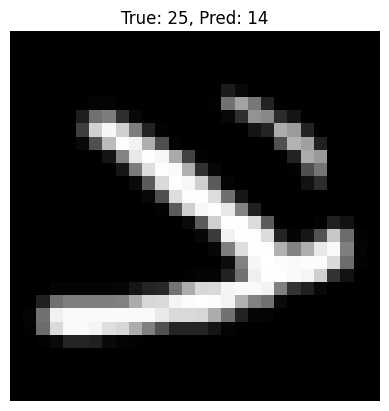

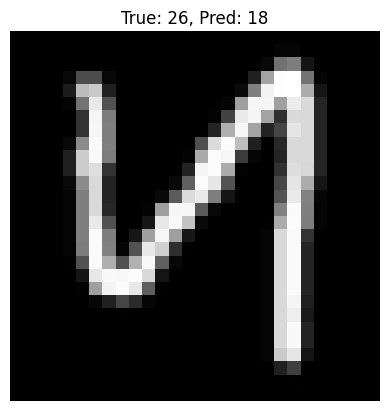

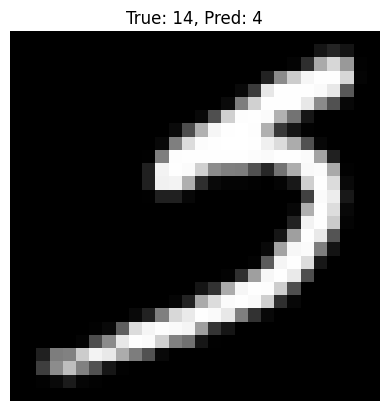

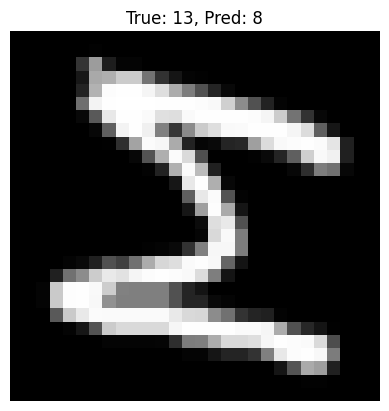

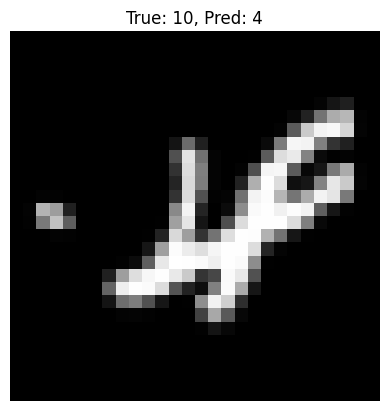

In [8]:

for i in range(len(xAll)):
    x = xAll[i]
    y = yAll[i]
    predict = predictAll[i]
    plt.figure()
    plt.imshow(x.squeeze(), cmap='gray')
    plt.title(f"True: {y}, Pred: {predict}")
    plt.axis('off')

In [7]:
# ===================== 4. 训练和测试函数 =====================
model = train(
    model=model, 
    x=train_loader, 
    y=None, 
    optimizer=optimizer, 
    criterion=criterion, 
    epochs=5, 
    patience=1, 
    device='mps'
)

Early stopping at epoch 2


In [8]:
correctPercent, wrongIndexes = evaluate_CNN(
    model=model, 
    x=test_loader, 
    y=None, 
    criterion=criterion, 
    device='mps'
)

In [ ]:
sampled_wrong = random.sample(wrongIndexes, min(5, len(wrongIndexes)))
xAll = []
yAll = []
preddictAll = []

In [16]:
for i in range(len(testDataset)):
    yAll.append(testDataset[i][1])

In [19]:
set(yAll)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26}

In [24]:
chr(ord('A') + 2)

'C'

In [21]:
yAll

[26, 8, 6, 26, 26]

In [22]:
sampled_wrong

[(20243, 21, 26), (5818, 4, 8), (4577, 7, 6), (20556, 9, 26), (20559, 24, 26)]

In [ ]:
    os.makedirs('figure', exist_ok=True)
    sampled_wrong = random.sample(wrongIndexes, min(5, len(wrongIndexes)))
    for idx in sampled_wrong:
        img, true_label = testDataset[idx]
        img_np = img.squeeze().numpy()
        model.eval()
        with torch.no_grad():
            input_img = img.unsqueeze(0).to(device)
            output = model(input_img)
            pred_label = output.argmax(dim=1).item()
        plt.figure()
        plt.imshow(img_np, cmap='gray')
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')
        plt.savefig(f'figure/wrong_pred_{idx}.png')
        plt.close()



In [36]:
# ===================== 5. 主训练循环 =====================
for epoch in range(5):
    loss = train_one_epoch()
    acc = evaluate()
    print(f"Epoch {epoch+1}: loss={loss:.4f}, test_acc={acc:.4f}")

# torch.save(model.state_dict(), "emnist_simplecnn.pth")
print("训练完成，模型已保存。")

Epoch 1: loss=1.0398, test_acc=0.8086
Epoch 2: loss=0.5621, test_acc=0.8489
Epoch 3: loss=0.4684, test_acc=0.8575
Epoch 4: loss=0.4240, test_acc=0.8727
Epoch 5: loss=0.3946, test_acc=0.8705
训练完成，模型已保存。
